In [1]:
#IMPORTS

#File IO
import os
import glob

#Data manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.nn.functional as F
from segmentation_models_pytorch import Unet

#Scikit learn
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import mean_squared_error, r2_score

#Misc
from tqdm import tqdm


In [2]:
#HYPERPARMETERS

train_proportion = .8
val_proportion = .1

batch_size = 256
learning_rate = .00001
num_epochs = 25

In [3]:
#CREATE DATASET

dataset = torch.load("phase_unet_dataset.pt", weights_only=False)

In [4]:
#CREATE DATALOADERS

train_size = int(train_proportion * len(dataset))
val_size = int(val_proportion * len(dataset))
test_size = len(dataset) - train_size - val_size

generator = torch.Generator().manual_seed(1)
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [5]:
#CREATE MODEL

num_classes = 5
model = Unet(
    encoder_name="resnet34",
    in_channels=16,
    classes=num_classes
)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()
model = model.to(device)

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

In [6]:
#TRAIN and EVALUATE FUNCTIONS

def train(model, train_loader):
    model.train()
    train_loss = correct = total = 0

    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        correct += (preds == labels).sum().item()
        total += labels.numel()

    #total is number of train instances
    avg_loss = train_loss/len(train_loader)
    accuracy = correct/total
    return avg_loss, accuracy

def eval(model, val_loader):
    model.eval()
    val_loss = correct = total = 0

    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=1)

        loss = criterion(outputs, labels)

        val_loss += loss.item()
        correct += (preds == labels).sum().item()
        total += labels.numel()

    avg_loss = val_loss/len(val_loader)
    accuracy = correct/total
    return avg_loss, accuracy

In [10]:
#TRAIN MODEL

for e in range(1, num_epochs+1):
    train_loss, train_acc = train(model, train_loader)
    val_loss, val_acc = eval(model, val_loader)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch: {e} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

100%|██████████| 47/47 [00:12<00:00,  3.75it/s]


Epoch: 1 | Train Loss: 0.5980 | Train Acc: 0.8254 | Val Loss: 0.6721 | Val Acc: 0.7897


100%|██████████| 47/47 [00:11<00:00,  3.97it/s]


Epoch: 2 | Train Loss: 0.5854 | Train Acc: 0.8291 | Val Loss: 0.6595 | Val Acc: 0.7955


100%|██████████| 47/47 [00:10<00:00,  4.31it/s]


Epoch: 3 | Train Loss: 0.5760 | Train Acc: 0.8311 | Val Loss: 0.6530 | Val Acc: 0.7988


100%|██████████| 47/47 [00:10<00:00,  4.30it/s]


Epoch: 4 | Train Loss: 0.5677 | Train Acc: 0.8325 | Val Loss: 0.6627 | Val Acc: 0.7953


100%|██████████| 47/47 [00:10<00:00,  4.30it/s]


Epoch: 5 | Train Loss: 0.5610 | Train Acc: 0.8339 | Val Loss: 0.6856 | Val Acc: 0.7844


100%|██████████| 47/47 [00:10<00:00,  4.31it/s]


Epoch: 6 | Train Loss: 0.5509 | Train Acc: 0.8364 | Val Loss: 0.6454 | Val Acc: 0.7983


100%|██████████| 47/47 [00:10<00:00,  4.30it/s]


Epoch: 7 | Train Loss: 0.5431 | Train Acc: 0.8378 | Val Loss: 0.6405 | Val Acc: 0.7991


100%|██████████| 47/47 [00:10<00:00,  4.31it/s]


Epoch: 8 | Train Loss: 0.5365 | Train Acc: 0.8391 | Val Loss: 0.6440 | Val Acc: 0.7913


100%|██████████| 47/47 [00:11<00:00,  4.23it/s]


Epoch: 9 | Train Loss: 0.5315 | Train Acc: 0.8398 | Val Loss: 0.6593 | Val Acc: 0.7899


100%|██████████| 47/47 [00:11<00:00,  4.23it/s]


Epoch: 10 | Train Loss: 0.5220 | Train Acc: 0.8423 | Val Loss: 0.6175 | Val Acc: 0.8031


100%|██████████| 47/47 [00:11<00:00,  4.26it/s]


Epoch: 11 | Train Loss: 0.5138 | Train Acc: 0.8444 | Val Loss: 0.6101 | Val Acc: 0.8043


100%|██████████| 47/47 [00:11<00:00,  4.25it/s]


Epoch: 12 | Train Loss: 0.5053 | Train Acc: 0.8466 | Val Loss: 0.6026 | Val Acc: 0.8074


100%|██████████| 47/47 [00:11<00:00,  4.04it/s]


Epoch: 13 | Train Loss: 0.5032 | Train Acc: 0.8461 | Val Loss: 0.6396 | Val Acc: 0.7942


100%|██████████| 47/47 [00:11<00:00,  3.96it/s]


Epoch: 14 | Train Loss: 0.4943 | Train Acc: 0.8486 | Val Loss: 0.6007 | Val Acc: 0.8065


100%|██████████| 47/47 [00:11<00:00,  3.99it/s]


Epoch: 15 | Train Loss: 0.4925 | Train Acc: 0.8479 | Val Loss: 0.5904 | Val Acc: 0.8082


100%|██████████| 47/47 [00:11<00:00,  4.00it/s]


Epoch: 16 | Train Loss: 0.4860 | Train Acc: 0.8498 | Val Loss: 0.6023 | Val Acc: 0.8045


100%|██████████| 47/47 [00:11<00:00,  4.08it/s]


Epoch: 17 | Train Loss: 0.4804 | Train Acc: 0.8506 | Val Loss: 0.7448 | Val Acc: 0.7472


100%|██████████| 47/47 [00:10<00:00,  4.30it/s]


Epoch: 18 | Train Loss: 0.4790 | Train Acc: 0.8504 | Val Loss: 0.6058 | Val Acc: 0.8017


100%|██████████| 47/47 [00:11<00:00,  4.25it/s]


Epoch: 19 | Train Loss: 0.4698 | Train Acc: 0.8532 | Val Loss: 0.6188 | Val Acc: 0.7954


100%|██████████| 47/47 [00:10<00:00,  4.29it/s]


Epoch: 20 | Train Loss: 0.4660 | Train Acc: 0.8538 | Val Loss: 0.5758 | Val Acc: 0.8098


100%|██████████| 47/47 [00:10<00:00,  4.32it/s]


Epoch: 21 | Train Loss: 0.4564 | Train Acc: 0.8568 | Val Loss: 0.6194 | Val Acc: 0.7942


100%|██████████| 47/47 [00:10<00:00,  4.31it/s]


Epoch: 22 | Train Loss: 0.4545 | Train Acc: 0.8566 | Val Loss: 0.5789 | Val Acc: 0.8092


100%|██████████| 47/47 [00:11<00:00,  4.24it/s]


Epoch: 23 | Train Loss: 0.4534 | Train Acc: 0.8561 | Val Loss: 0.5786 | Val Acc: 0.8062


100%|██████████| 47/47 [00:11<00:00,  4.18it/s]


Epoch: 24 | Train Loss: 0.4453 | Train Acc: 0.8586 | Val Loss: 0.5636 | Val Acc: 0.8130


100%|██████████| 47/47 [00:11<00:00,  3.94it/s]


Epoch: 25 | Train Loss: 0.4409 | Train Acc: 0.8597 | Val Loss: 0.5796 | Val Acc: 0.8067


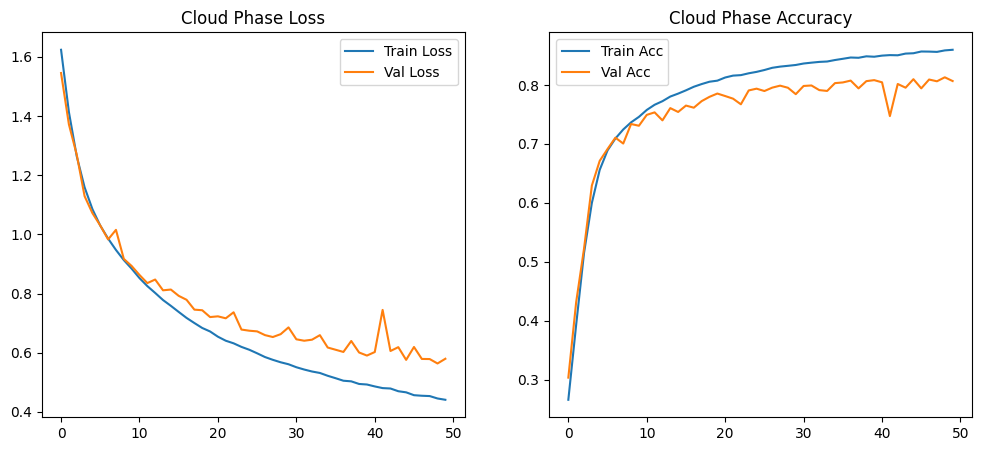

In [11]:
#PLOT LOSS and ACCURACY

plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Cloud Phase Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.title('Cloud Phase Accuracy')
plt.legend()

plt.savefig("./graphs/unet_cloud_phase.png")  

plt.show()

In [12]:
#MODEL EVALUATION

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)

        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())
        
all_preds = np.concatenate([p.flatten() for p in all_preds])
all_labels = np.concatenate([l.flatten() for l in all_labels])


report = classification_report(all_labels, all_preds, digits=3, output_dict=True)
f1_scores = np.array([report[str(i)]['f1-score'] for i in range(num_classes)])
supports = np.array([report[str(i)]['support'] for i in range(num_classes)])
iou = f1_scores / (2 - f1_scores)

print("REPORT:\n", classification_report(all_labels, all_preds, digits=3))
print("CONFUSION MATRIX:\n", confusion_matrix(all_labels, all_preds))
print("\nIOU:", iou)
print("Unweighted:", np.mean(iou))
print("Weighted:", np.average(iou, weights=supports))

100%|██████████| 6/6 [00:01<00:00,  4.73it/s]


REPORT:
               precision    recall  f1-score   support

           0      0.821     0.833     0.827   3755747
           1      0.856     0.862     0.859  10402337
           2      0.761     0.749     0.755   3957330
           3      0.338     0.244     0.283   1276455
           4      0.785     0.829     0.806   5184131

    accuracy                          0.800  24576000
   macro avg      0.712     0.703     0.706  24576000
weighted avg      0.794     0.800     0.796  24576000

CONFUSION MATRIX:
 [[3128248  544364   21905    5363   55867]
 [ 571807 8969393  350346   78726  432065]
 [  20395  324195 2965850  364751  282139]
 [   2454  126044  431022  311290  405645]
 [  86510  512030  128111  162085 4295395]]

IOU: [0.70505056 0.75316278 0.60667284 0.16493234 0.67539282]
Unweighted: 0.5810422687666102
Weighted: 0.6752646002177303
